In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

C:\Users\kisha\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Load and preprocess data

In [2]:
df = pd.read_csv("../../datasets/latestdataset - Copy.csv")

# Drop unwanted columns 
df.drop(columns=["rain (mm)", "precipitation (mm)", "soil_moisture_0_to_7cm (m³/m³)"], inplace=True)

# Parse datetime
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')

# Convert to float
df = df.astype(float)

In [3]:
df.head()

,temperature_2m (°C),relative_humidity_2m (%),wind_speed_10m (km/h),soil_temperature_0_to_7cm (°C)
time,,,,
2015-01-01 00:00:00,20.2,96.0,6.6,22.2
2015-01-01 01:00:00,20.2,95.0,9.3,22.0
2015-01-01 02:00:00,20.3,96.0,10.5,22.0
2015-01-01 03:00:00,21.1,93.0,8.7,22.4
2015-01-01 04:00:00,22.5,86.0,8.2,23.3


# Scale data

In [4]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.values)

df_scaled = pd.DataFrame(scaled, index=df.index, columns=df.columns)

# ----------------------
# Create sequences for supervised learning
# ----------------------

In [5]:
def create_sequences(data, lookback=72, horizon=6):
    X, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+horizon])  # multi-step target
    return np.array(X), np.array(y)

# Inverse Scaling helper

In [6]:
def inverse_scale_preds(y_scaled, scaler):
    samples, H, F = y_scaled.shape
    y_inv = np.zeros_like(y_scaled)
    for h in range(H):
        y_inv[:, h, :] = scaler.inverse_transform(y_scaled[:, h, :])
    return y_inv

# Data Preparation

In [8]:
lookback = 72
horizon = 6
n_features = df_scaled.shape[1]   # after excluding rain/precipitation/soil moisture

X, y = create_sequences(df_scaled, lookback, horizon)

# Flatten targets for training (Keras Dense expects 2D output)
y_flat = y.reshape((y.shape[0], -1))  # (samples, horizon * n_features)

# Train-test split

In [9]:
# Train/Val/Test split
train_size = int(len(X) * 0.7)
val_size   = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y_flat[:train_size]
X_val,   y_val   = X[train_size:train_size+val_size], y_flat[train_size:train_size+val_size]
X_test,  y_test  = X[train_size+val_size:], y_flat[train_size+val_size:]

# Build GRU model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

model = Sequential([
    GRU(128, return_sequences=False, input_shape=(lookback, n_features)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(horizon * n_features)   # flattened multi-step output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 128)               51456     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 24)                1560      
                                                                 
Total params: 61,272
Trainable params: 61,272
Non-trainable params: 0
_________________________________________________________________


# Training

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5),
    ModelCheckpoint("best_gru.h5", save_best_only=True, monitor="val_loss")
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
959/959 [==============================] - 65s 65ms/step - loss: 0.0106 - mae: 0.0675 - val_loss: 0.0033 - val_mae: 0.0405 - lr: 0.0010
Epoch 2/100
959/959 [==============================] - 64s 67ms/step - loss: 0.0034 - mae: 0.0422 - val_loss: 0.0030 - val_mae: 0.0380 - lr: 0.0010
Epoch 3/100
959/959 [==============================] - 68s 71ms/step - loss: 0.0030 - mae: 0.0389 - val_loss: 0.0028 - val_mae: 0.0368 - lr: 0.0010
Epoch 4/100
959/959 [==============================] - 77s 80ms/step - loss: 0.0028 - mae: 0.0376 - val_loss: 0.0027 - val_mae: 0.0362 - lr: 0.0010
Epoch 5/100
959/959 [==============================] - 77s 81ms/step - loss: 0.0027 - mae: 0.0368 - val_loss: 0.0026 - val_mae: 0.0350 - lr: 0.0010
Epoch 6/100
959/959 [==============================] - 72s 75ms/step - loss: 0.0026 - mae: 0.0362 - val_loss: 0.0026 - val_mae: 0.0350 - lr: 0.0010
Epoch 7/100
959/959 [==============================] - 81s 84ms/step - loss: 0.0026 - mae: 0.0357 - val_loss: 0.

Epoch 55/100
959/959 [==============================] - 66s 69ms/step - loss: 0.0022 - mae: 0.0320 - val_loss: 0.0023 - val_mae: 0.0322 - lr: 1.0000e-05
Epoch 56/100
959/959 [==============================] - 77s 80ms/step - loss: 0.0022 - mae: 0.0320 - val_loss: 0.0023 - val_mae: 0.0322 - lr: 1.0000e-05
Epoch 57/100
959/959 [==============================] - 76s 79ms/step - loss: 0.0022 - mae: 0.0319 - val_loss: 0.0023 - val_mae: 0.0322 - lr: 1.0000e-05
Epoch 58/100
959/959 [==============================] - 73s 76ms/step - loss: 0.0022 - mae: 0.0319 - val_loss: 0.0023 - val_mae: 0.0322 - lr: 1.0000e-05
Epoch 59/100
959/959 [==============================] - 71s 74ms/step - loss: 0.0022 - mae: 0.0319 - val_loss: 0.0023 - val_mae: 0.0322 - lr: 1.0000e-05
Epoch 60/100
959/959 [==============================] - 71s 74ms/step - loss: 0.0022 - mae: 0.0319 - val_loss: 0.0023 - val_mae: 0.0322 - lr: 1.0000e-05
Epoch 61/100
959/959 [==============================] - 88s 92ms/step - loss: 0.00

# Load the saved model

In [18]:
from tensorflow.keras.models import load_model

# load saved model
model = load_model('best_gru.h5')

# Evaluation

In [19]:
# Predictions
y_pred_flat = model.predict(X_test)
y_pred = y_pred_flat.reshape((y_pred_flat.shape[0], horizon, n_features))
y_true = y_test.reshape((y_test.shape[0], horizon, n_features))

# Inverse scaling
y_pred_inv = inverse_scale_preds(y_pred, scaler)
y_true_inv = inverse_scale_preds(y_true, scaler)

411/411 [==============================] - 6s 14ms/step


In [23]:
# Metrics (per feature & horizon)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

selected_features = [
    "temperature_2m (°C)",
    "relative_humidity_2m (%)",
    "wind_speed_10m (km/h)",
    "soil_temperature_0_to_7cm (°C)"
]

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# -------------------------------
# Assume:
# y_true_inv.shape = (samples, horizon, n_features)
# y_pred_inv.shape = (samples, horizon, n_features)
# selected_features = ["temperature_2m (°C)", "relative_humidity_2m (%)", 
#                      "wind_speed_10m (km/h)", "soil_temperature_0_to_7cm (°C)"]
# horizon = 6   # (or 1 if you do single-step)
# -------------------------------

results = {}
averages = {}

for f_idx, feature in enumerate(selected_features):
    results[feature] = {}
    mae_list, rmse_list, r2_list = [], [], []
    
    for h in range(horizon):
        y_true_h = y_true_inv[:, h, f_idx]
        y_pred_h = y_pred_inv[:, h, f_idx]

        mae  = mean_absolute_error(y_true_h, y_pred_h)
        rmse = np.sqrt(mean_squared_error(y_true_h, y_pred_h))
        r2   = r2_score(y_true_h, y_pred_h)

        results[feature][f"Horizon_{h+1}"] = {
            "MAE": mae, "RMSE": rmse, "R2": r2
        }

        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
    # Average across all horizons for this feature
    averages[feature] = {
        "MAE_avg": np.mean(mae_list),
        "RMSE_avg": np.mean(rmse_list),
        "R2_avg": np.mean(r2_list)
    }

# Convert to DataFrames for readability
per_horizon_df = pd.DataFrame.from_dict(
    {(f,h): results[f][h] for f in results for h in results[f]},
    orient="index"
)
avg_df = pd.DataFrame(averages).T

print("===== Metrics per Feature & Horizon =====")
print(per_horizon_df)
print("\n===== Average per Feature =====")
print(avg_df)

===== Metrics per Feature & Horizon =====
                                               MAE      RMSE        R2
temperature_2m (°C)            Horizon_1  0.410173  0.614191  0.978246
                               Horizon_2  0.549157  0.776303  0.965253
                               Horizon_3  0.625379  0.870780  0.956291
                               Horizon_4  0.669580  0.927780  0.950393
                               Horizon_5  0.706851  0.970924  0.945686
                               Horizon_6  0.736956  1.006914  0.941603
relative_humidity_2m (%)       Horizon_1  2.339119  3.527463  0.973315
                               Horizon_2  3.276507  4.636887  0.953891
                               Horizon_3  3.849691  5.330110  0.939079
                               Horizon_4  4.225628  5.809256  0.927642
                               Horizon_5  4.499806  6.170607  0.918370
                               Horizon_6  4.692028  6.427214  0.911450
wind_speed_10m (km/h)          Hori

# Plot results (first column only) - Extra (part of old code)

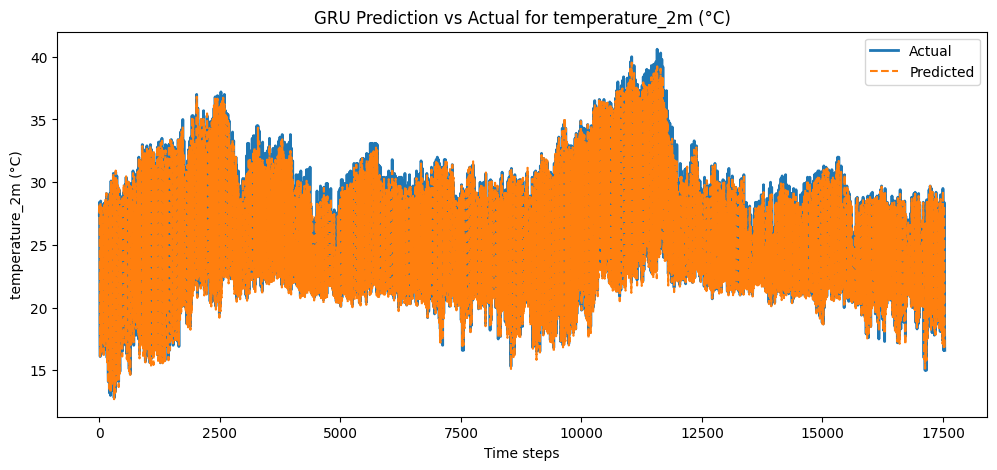

In [31]:
col_index = 0
plt.figure(figsize=(12,5))
plt.plot(y_test_inv[:, col_index], label="Actual", linewidth=2)
plt.plot(y_pred_inv[:, col_index], label="Predicted", linestyle="--")
plt.title(f"GRU Prediction vs Actual for {df.columns[col_index]}")
plt.xlabel("Time steps")
plt.ylabel(df.columns[col_index])
plt.legend()
plt.show()

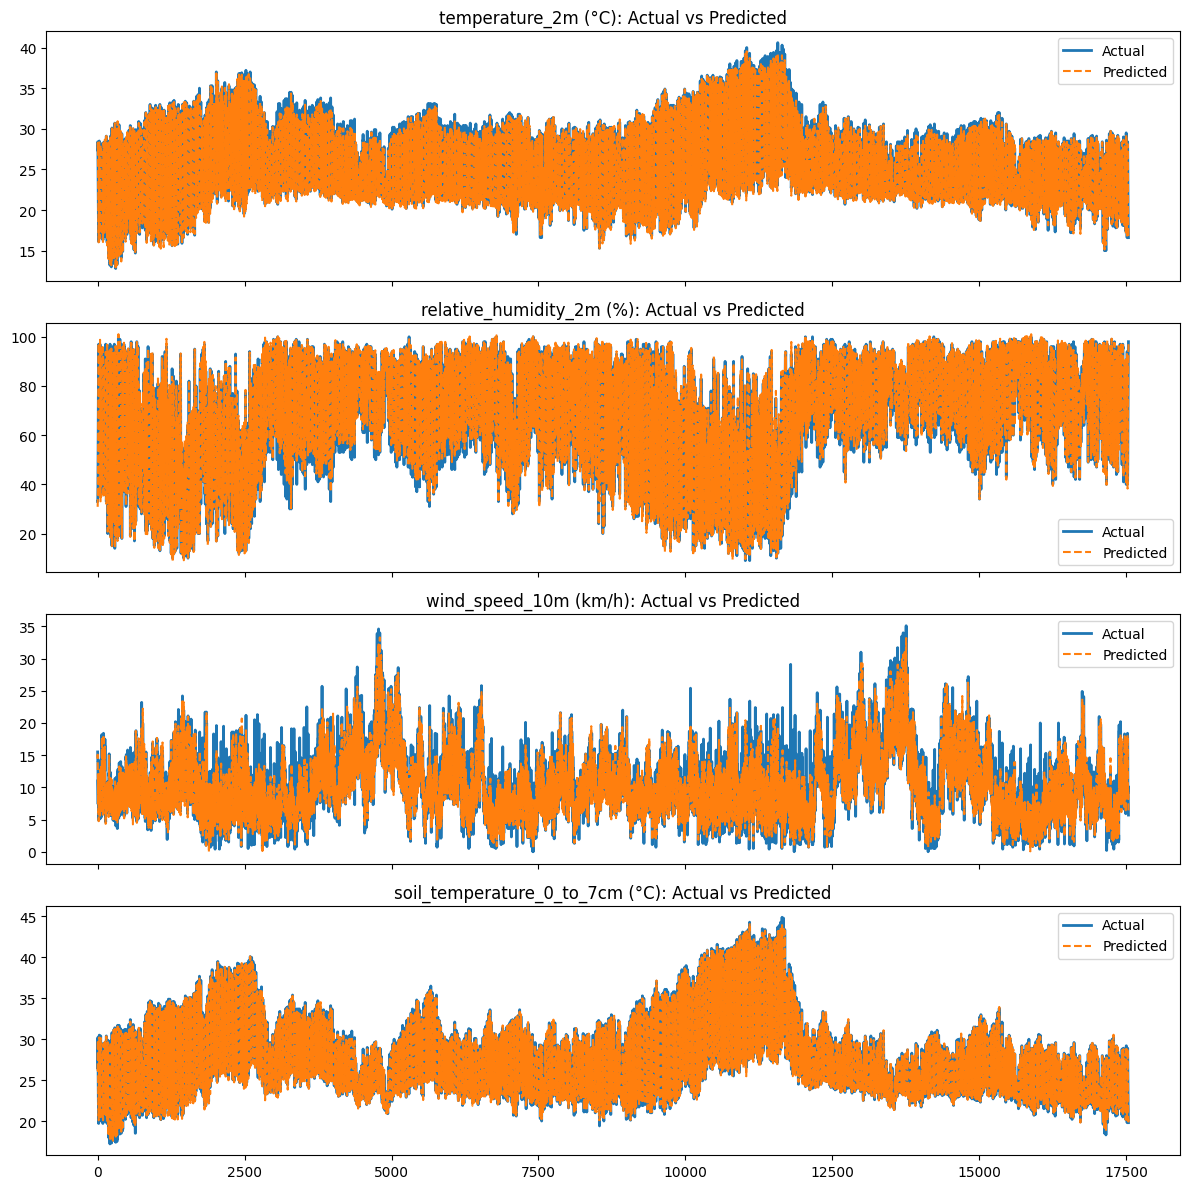

In [22]:
# Plot all columns
# ----------------------
n_cols = y_test_inv.shape[1]
fig, axes = plt.subplots(n_cols, 1, figsize=(12, 3*n_cols), sharex=True)

for i in range(n_cols):
    axes[i].plot(y_test_inv[:, i], label="Actual", linewidth=2)
    axes[i].plot(y_pred_inv[:, i], label="Predicted", linestyle="--")
    axes[i].set_title(f"{df.columns[i]}: Actual vs Predicted")
    axes[i].legend()

plt.tight_layout()
plt.show()

In [32]:
n_features = y_test.shape[1]
feature_names = df.columns  # original feature names from your dataset

results = []

for i in range(n_features):
    y_true = y_test[:, i]
    y_hat = y_pred[:, i]

    mae = mean_absolute_error(y_true, y_hat)
    rmse = mean_squared_error(y_true, y_hat, squared=False)  # RMSE
    mape = np.mean(np.abs((y_true - y_hat) / y_true)) * 100
    r2 = r2_score(y_true, y_hat)

    results.append({
        "feature": feature_names[i],
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

print("===== GRU =====")
print(results_df.to_string(index=False))

===== GRU =====
                       feature      MAE     RMSE     MAPE       R2
           temperature_2m (°C) 0.015991 0.024004 3.868459 0.976317
      relative_humidity_2m (%) 0.025650 0.038637 4.890384 0.974403
         wind_speed_10m (km/h) 0.038659 0.054879      inf 0.830177
soil_temperature_0_to_7cm (°C) 0.009432 0.014405 2.788140 0.990340


C:\Users\krati\AppData\Local\Temp\ipykernel_3656\2018184666.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_hat) / y_true)) * 100


In [19]:
y_test.shape

(17538, 4)